<a href="https://colab.research.google.com/github/MarkPilling/MarkPilling/blob/main/Levelling_Up_White_Paper_Text_Mining_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Levelling Up White Paper Text Mining Analysis
---
This notebook contains the Python code used to extract and analyse text from the [Levelling Up White Paper](https://www.gov.uk/government/publications/levelling-up-the-united-kingdom) published by the UK Government on 2 February 2022. In particular, this notebook contains code to run text mining analysis on the take-up of policies announced under the 2017 Industrial Strategy or the 2021 Plan for Growth and Innovation Strategy. The "[Levelling Up for the long term](https://www.bennettinstitute.cam.ac.uk/blog/levelling-long-term/)" blog article published summarises the key findings from this analysis

## Setting up Google Colab environment

We set up our Colab notebook by installing, importing, and enabling the use of various Python libraries containing built-in data science (e.g. NumPy, Pandas, etc.) and text mining (PyMuPDF) functions.

In [ ]:
#@title Install latest version of packages relevant for text analysis
!pip install --upgrade PyMuPDF      # https://pymupdf.readthedocs.io/en/latest/

     |████████████████████████████████| 8.7 MB 4.8 MB/s 


In [ ]:
#@title Import Python libraries
# Basic Python data science libraries
import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import fitz             # text extraction via PyMuPDF
import itertools        # iterator functions (https://docs.python.org/3/library/itertools.html)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
#@title Wrap plot labels
import textwrap
def wrap_xlabels(ax, width, break_long_words = False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width = width,
                                    break_long_words = break_long_words))
    ax.set_xticklabels(labels, rotation = 0)

def wrap_ylabels(ax, width, break_long_words = False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width = width,
                                    break_long_words = break_long_words))
    ax.set_yticklabels(labels, rotation = 00)

#### Economic strategy terms used

In [ ]:
#@title Tokenising terms
# Author's edit: There is a 'cleaner' way of doing this, by installing and
# using the Python's ::regex:: package.

ip_terms_2017 = ['Business, Energy and Industrial Strategy',
                 'Business, Energy & Industrial Strategy', 'Industrial Strategy Council',
                 'Industrial Strategy Challenge Fund',
                 'Local Industrial Strategy', 'Local industrial strategy',
                 'local industrial strategy', 'Local Industrial Strategies',
                 'Local industrial strategies', 'local industrial strategies',
                 "Defence and Security Industrial Strategy",    # From Plan for Growth
                 'Industrial Strategy', 'industrial strategy', 'ISCF', 'Grand Challenges',
                 'grand challenges', 'National Productivity Investment Fund', 'NIPF',
                 'Transforming Cities Fund', 'TCF', '5G Testbeds and Trials Programme',
                 '5GTT', 'National Retraining Scheme', 'Teacher Development Premium',
                 'Midlands Engine', 'Northern Powerhouse',  'Office for Students',
                 'OfS', 'Skills Plan', 'Teaching for Mastery', 'T Level', 'T level',
                 ' T Level', ' T level', 'Cyber Discovery programme', 'Cyber Discovery',
                 'National Centre for Computing Education', 'Institute of Coding',
                 'Smart Systems and Flexibility Plan', 'Smart Islands programme', 
                 'Smart Islands', 'Local Growth Fund', 'Bioeconomy Strategy',
                 'Barrier Removal Task Force',
                 'Local Full-fibre Networks Challenge Fund', 'Networks Challenge Fund',
                 'Geospatial Commission', 'Centre for Data Ethics and Innovation',
                 'Venture Capital Trusts', 'VCTs', 'Enterprise Investment Scheme', 'EIS',
                 'Enterprise Capital Fund', 'National Security Strategic Investment Fund',
                 'Enterprise Finance Guarantee', 'Business Basics Programme',
                 'UK Trade Commissioners', 'R&D Expenditure Credit', 'Advanced Clearance Service for R&D',
                 'Regional Skills Partnerships', 'Regional Skills Assessments',
                 'Skills Advisory Panels', '25 Year Environment Plan', '25 year Environment Plan'
                 '25-Year Environment Plan', '25-year Environment Plan', 
                 'Sector Deals', 'Sector deals', 'sector deals',
                 'Sector Deal', 'Sector deal', 'sector deal', 'Aerospace', 'aerospace',
                 'Automotive', 'automotive', 'Construction', 'construction',
                 'Creative Industries', 'Creative industries', 'creative industries',
                 'Life Sciences', 'Life sciences', 'life sciences', 'Nuclear', 'nuclear',
                 'Offshore Wind', 'Offshore wind', 'offshore wind', 'Rail', 'rail',
                 'Tourism', 'tourism', 'Missions', 'missions', 'Artificial Intelligence',
                 'artificial intelligence', 'AI', '(AI)', ' AI ', ' AI.', ' AI,', 'AI deal', 'AI sector deal',
                 'AI Sector Deal', 'AI Deal', 'Ageing Society', 'Ageing society',
                 'ageing society', 'Clean growth', 'Clean Growth', 'clean growth',
                 'Future of Mobility', 'Future of mobility', 'future of mobility',
                 'Financial Services', 'Financial services', 'financial services',
                 'Financial Services Technology', 'Financial services technology',
                 'financial services technology', 'FinTech', 'Fintech', 'fintech',
                 'Railway', 'railway', 'trail', ' rail ', ' rail.', ' rail,']

ip_terms_2021 = ["Build Back Better", "Plan for Growth", "plan for growth",
                 "Plan for Jobs", "plan for jobs", "Ten Point Plan", "ten point plan",
                 "Green Industrial Revolution", "Heat and Buildings Strategy",
                 "Transport Decarbonisation Plan", 'Transforming Cities Fund',
                 'TCF', 'Future Fund: Breakthrough', 'Future Fund', 'Lifetime Skills Guarantee',
                 'Lifelong Loan Entitlement', 'Towns Fund', 'High Street Fund',
                 'Strength in Places Fund', 'Connecting Capability Fund', 'Prosperity Partnership',
                 "Help to Grow", 'help to grow', 'Kickstart Scheme', 'Kickstart scheme',
                 'kickstart scheme', 'Restart Programme', 'Restart programme',
                 'Innovation Strategy', 'Innovation strategy', 'innovation strategy',
                 'innovation missions', 'Emerging Skills Programme',
                 'National Quantum Computing Centre', 'National Science and Technology Council',
                 'Office for Science and Technology', 'Business Innovation Forum',
                 'National Skills Fund', 'National Home Building Fund', 'Brownfield Fund',
                 'Freeports', 'Carbon Capture Usage and Storage', 'CCUS Infrastructure Fund',
                 'low carbon hydrogen fund', 'hydrogen fund', 'Green Recovery Challenge Fund',
                 "Industrial Decarbonisation Strategy", "Net Zero Strategy",
                 "International Climate Finance", "UK Emissions Trading Scheme",
                 "Green Gilt", "Green Finance Market", "Green Taxonomy",
                 "UK Infrastructure Bank", "Office for Investment",
                 "Shared Prosperity Fund", "UKSPF", "(UKSPF)", "Levelling Up Fund",
                 "National Security and Investment Bill", "Integrated Rail Plan",
                 "Union Connectivity Review", "UK Gigabit Programme", "Shared Rural Network",
                 "Advanced Research & Invention Agency", "ARIA",
                 "Advanced Research and Invention Agency", "Places for Growth",
                 "Internationalisation Fund", "Knowledge Assets Implementation Strategy",
                 "Hydrogen Strategy", "Lifelong Loan Entitlement Consultation",
                 "National Space Strategy", "Research & Development Places Strategy",
                 "R&D Places Strategy", "R&D People and Culture Strategy",
                 "Research & Development People and Culture Strategy",
                 "Procurement Reform", "Sector Visions", "Trade Remedies Authority",
                 "Innovation Missions", "Action Plan on Standards", "Action Plan",
                 "Standards for the Fourth Industrial Revolution Project Board",
                 "Regulatory Horizons Council", "National Quality Infrastructure",
                 "National AI Strategy", "Commercialisation Funding Framework",
                 "Innovate UK EDGE", "Made Smarter Adoption", "NQI",
                 "Government Office for Technology Transfer", "Skills Value Chain",
                 "Prosperity Partnerships", "Kickstart jobs",
                 "Business Innovation Forum", "Project Gigabit",
                 "Defence and Security Industrial Strategy", "DSIS"]

## Extracting text from Department for Levelling Up, Housing and Communities (DLUHC) publications

This section details code used for text extraction and word frequency analysis done on the following DLUHC publications:
* [Levelling Up White Paper](https://www.gov.uk/government/publications/levelling-up-the-united-kingdom).

In [ ]:
#@title Uploading PDF files directly into the Colab notebook
from google.colab import files
file_uploaded = files.upload()
# Uploaded files temporarily stored at "/content/..."

Saving Levelling Up White Paper.pdf to Levelling Up White Paper.pdf


In [ ]:
dluhc_docs = ["Levelling Up White Paper.pdf"]

In [ ]:
#@title Text extraction via PyMuPDF
for i in range(0, len(dluhc_docs)):
    fname = dluhc_docs[i]  # get document filename
    doc = fitz.open(fname)  # open document
    out = open(fname + ".txt", "wb")  # open text output
    for page in doc:  # iterate the document pages
        text = page.get_text().encode("utf8")  # get plain text (is in UTF-8)
        out.write(text)  # write text of page
        out.write(bytes((12,)))  # write page delimiter (form feed 0x0C)
    out.close()

In [ ]:
#@title Creating paired-list of extracted text file names & contents
dluhc_docs_newname = []
dluhc_docs_parsed = []

for i in range(0, len(dluhc_docs)):
    dluhc_docs_newname.append(dluhc_docs[i][:-4])
    dluhc_docs_parsed.append(dluhc_docs[i] + ".txt")

# Removing newline characters and extra spaces
for i in range(0, len(dluhc_docs_parsed)):
    dluhc_docs_parsed[i] = open(dluhc_docs_parsed[i]).read()
    dluhc_docs_parsed[i] = dluhc_docs_parsed[i].replace(' \n', ' ')
    dluhc_docs_parsed[i] = dluhc_docs_parsed[i].replace('\n', ' ')
    dluhc_docs_parsed[i] = dluhc_docs_parsed[i].replace('   ', ' ')
    dluhc_docs_parsed[i] = dluhc_docs_parsed[i].replace('  ', ' ')

# Creating dictionary mapping file names to text extracted
dluhc_docs_pairs = dict(zip(dluhc_docs_newname, dluhc_docs_parsed))

In [ ]:
# Check if pair assignment is correct
dluhc_docs_pairs["Levelling Up White Paper"]

"Levelling Up the United Kingdom \x0c\x0c Levelling Up the United Kingdom Presented to Parliament by the Secretary of State for Levelling Up, Housing and Communities by Command of Her Majesty 2 February 2022 CP 604 \x0c © Crown copyright 2022 This publication is licensed under the terms of the Open Government Licence v3.0 except where otherwise stated. To view this licence, visit nationalarchives.gov.uk/doc/open-government-licence/ version/3. Where we have identifed any third party copyright information you will need to obtain permission from the copyright holders concerned. This publication is available at www.gov.uk/official-documents Any enquiries regarding this publication should be sent to us at: correspondence@levellingup.gov.uk ISBN 978-1-5286-3017-7 E02694177 02/22 Printed on paper containing 75% recycled fbre content minimum Printed in the UK by HH Associates Ltd. on behalf of the Controller of Her Majesty’s Stationery Ofce \x0c         Contents Foreword by the Prime Minister 

In [ ]:
#@title 2017 Industrial Strategy terms frequency count
dluhc_ip_terms_2017_count = pd.DataFrame(index = dluhc_docs_newname, columns = ip_terms_2017)
new_row = []

# Tallying frequency of word occurrences from ip_terms_2017
for i in range(0, len(dluhc_docs_newname)):
    for j in range(0, len(ip_terms_2017)):
        new_row.extend([dluhc_docs_pairs[dluhc_docs_newname[i]].count(ip_terms_2017[j])])
    dluhc_ip_terms_2017_count.loc[dluhc_docs_newname[i]] = new_row
    new_row = []

# Removing "Industrial Strategy" duplicates due to BEIS department name
dluhc_ip_terms_2017_count = dluhc_ip_terms_2017_count.astype(str).astype(int)
dluhc_ip_terms_2017_count["Industrial Strategy_nonBEIS"] = dluhc_ip_terms_2017_count[["Industrial Strategy",
                                                                                      "industrial strategy"]].sum(axis = 1)
for i in range (0, ip_terms_2017.index("Industrial Strategy")):
    dluhc_ip_terms_2017_count["Industrial Strategy_nonBEIS"] -= dluhc_ip_terms_2017_count.iloc[:, i]

# Print dataframe
dluhc_ip_terms_2017_count.loc[:, (dluhc_ip_terms_2017_count != 0).any(axis = 0)]    # Remove columns containing only zeros

,"Business, Energy and Industrial Strategy",Industrial Strategy Council,local industrial strategy,Defence and Security Industrial Strategy,Industrial Strategy,industrial strategy,Transforming Cities Fund,Midlands Engine,Northern Powerhouse,OfS,T Level,T Level,Local Growth Fund,EIS,25 Year Environment Plan,25-year Environment Plan,Aerospace,aerospace,Automotive,automotive,Construction,construction,Creative Industries,Creative industries,creative industries,Life Sciences,life sciences,Nuclear,nuclear,Rail,rail,Tourism,tourism,Missions,missions,AI,AI,"AI,",Clean Growth,clean growth,future of mobility,FinTech,Fintech,Railway,railway,trail,rail,rail.
Levelling Up White Paper,6,12,1,1,19,1,12,7,10,3,1,1,5,49,3,1,4,3,7,4,1,2,2,1,5,5,5,4,3,22,42,4,15,12,97,3,2,1,1,1,1,3,5,3,8,5,25,1


In [ ]:
#@title Plan for Growth/Innovation Strategy terms frequency count
dluhc_ip_terms_2021_count = pd.DataFrame(index = dluhc_docs_newname, columns = ip_terms_2021)
new_row = []

# Tallying frequency of word occurrences from ip_terms_2021
for i in range(0, len(dluhc_docs_newname)):
    for j in range(0, len(ip_terms_2021)):
        new_row.extend([dluhc_docs_pairs[dluhc_docs_newname[i]].count(ip_terms_2021[j])])
    dluhc_ip_terms_2021_count.loc[dluhc_docs_newname[i]] = new_row
    new_row = []

# Print dataframe
dluhc_ip_terms_2021_count = dluhc_ip_terms_2021_count.astype(str).astype(int)
dluhc_ip_terms_2021_count.loc[:, (dluhc_ip_terms_2021_count != 0).any(axis = 0)]    # Remove columns containing only zeros

,Plan for Jobs,Ten Point Plan,Green Industrial Revolution,Transforming Cities Fund,Lifetime Skills Guarantee,Lifelong Loan Entitlement,Towns Fund,Strength in Places Fund,Help to Grow,Innovation Strategy,Freeports,Net Zero Strategy,UK Infrastructure Bank,Shared Prosperity Fund,UKSPF,(UKSPF),Levelling Up Fund,Integrated Rail Plan,Union Connectivity Review,Shared Rural Network,Places for Growth,Hydrogen Strategy,Action Plan,Kickstart jobs,Project Gigabit,Defence and Security Industrial Strategy,DSIS
Levelling Up White Paper,1,4,2,12,4,1,32,13,3,11,11,9,2,9,13,4,52,7,1,10,9,1,1,11,10,1,3


In [ ]:
#@title Combining frequency counts
# Plan for Growth terms
dluhc_planforgrowth = dluhc_ip_terms_2021_count[["Plan for Growth",
                 "Plan for Jobs", "Ten Point Plan", "Green Industrial Revolution",
                 "Heat and Buildings Strategy", "Transport Decarbonisation Plan",
                 'Transforming Cities Fund', 'Future Fund: Breakthrough',
                 "Levelling Up Fund", "Places for Growth",
                 'Lifetime Skills Guarantee', 'Lifelong Loan Entitlement', 'Towns Fund', 'High Street Fund',
                 'Strength in Places Fund', 'Prosperity Partnership',
                 "Help to Grow", 'Kickstart Scheme', 'Restart Programme',
                 'National Skills Fund', 'National Home Building Fund', 'Brownfield Fund',
                 'Freeports', 'CCUS Infrastructure Fund', 'Green Recovery Challenge Fund',
                 "Industrial Decarbonisation Strategy", "Net Zero Strategy",
                 "International Climate Finance", "UK Emissions Trading Scheme",
                 "Green Gilt", "Green Finance Market", "Green Taxonomy",
                 "UK Infrastructure Bank", "Office for Investment",
                 "National Security and Investment Bill", "Integrated Rail Plan",
                 "Union Connectivity Review", "Project Gigabit", "Shared Rural Network",
                 "Advanced Research & Invention Agency", "Internationalisation Fund",
                 "Knowledge Assets Implementation Strategy",
                 "Hydrogen Strategy", "National Space Strategy", "R&D Places Strategy",
                 "R&D People and Culture Strategy",
                 "Procurement Reform", "Sector Visions", "Trade Remedies Authority",
                 "Defence and Security Industrial Strategy"]]

dluhc_planforgrowth["UK Shared Prosperity Fund"] = dluhc_ip_terms_2021_count[["Shared Prosperity Fund",
                                                                              "UKSPF"]].sum(axis = 1)

dluhc_planforgrowth["UK Shared Prosperity Fund"] = dluhc_planforgrowth["UK Shared Prosperity Fund"] - 8
dluhc_planforgrowth["Kickstart scheme"] = dluhc_ip_terms_2021_count[["Kickstart jobs"]]


dluhc_planforgrowth = dluhc_planforgrowth.transpose()
dluhc_planforgrowth = dluhc_planforgrowth.sort_values(by = "Levelling Up White Paper",
                                                      ascending = False)


# Innovation Strategy terms
dluhc_innovationstrategy = dluhc_ip_terms_2021_count[["Innovation Strategy", "Innovation Missions",
                            "Action Plan on Standards", "Regulatory Horizons Council",
                            "National AI Strategy", "Commercialisation Funding Framework",
                            "Innovate UK EDGE", "Made Smarter Adoption",
                            "Help to Grow", "R&D Places Strategy", "R&D People and Culture Strategy",
                            "Government Office for Technology Transfer",
                            "Emerging Skills Programme", "Skills Value Chain",
                            "Advanced Research & Invention Agency",
                            "Strength in Places Fund", "Connecting Capability Fund",
                            "Prosperity Partnerships",
                            "National Quantum Computing Centre",
                            "National Science and Technology Council",
                            "Office for Science and Technology", "Business Innovation Forum"]]


dluhc_innovationstrategy = dluhc_innovationstrategy.transpose()
dluhc_innovationstrategy = dluhc_innovationstrategy.sort_values(by = "Levelling Up White Paper",
                                                                ascending = False)


# 2017 Industrial Strategy terms
dluhc_industrialstrategy = dluhc_ip_terms_2017_count[["Industrial Strategy_nonBEIS",
                                                      "Grand Challenges",
                                                      "Sector Deals",
                                                      "Industrial Strategy Challenge Fund",
                                                      "National Productivity Investment Fund",
                                                      "National Retraining Scheme",
                                                      "Transforming Cities Fund",
                                                      "Teacher Development Premium",
                                                      "local industrial strategy",
                                                      "future of mobility",'5G Testbeds and Trials Programme',
                 'Midlands Engine', 'Northern Powerhouse',  'OfS',
                 'Skills Plan', 'Teaching for Mastery',
                 'Cyber Discovery programme', 'National Centre for Computing Education',
                 'Institute of Coding', 'Smart Systems and Flexibility Plan',
                 'Smart Islands programme',  'Smart Islands', 'Local Growth Fund',
                 'Bioeconomy Strategy', 'Barrier Removal Task Force',
                 'Local Full-fibre Networks Challenge Fund', 'Networks Challenge Fund',
                 'Geospatial Commission', 'Centre for Data Ethics and Innovation',
                 'Venture Capital Trusts', 'Enterprise Investment Scheme',
                 'Enterprise Capital Fund', 'National Security Strategic Investment Fund',
                 'Enterprise Finance Guarantee', 'Business Basics Programme',
                 'UK Trade Commissioners', 'R&D Expenditure Credit', 'Advanced Clearance Service for R&D',
                 'Regional Skills Partnerships', 'Regional Skills Assessments',
                 'Skills Advisory Panels']]
dluhc_industrialstrategy = dluhc_industrialstrategy.rename(columns = {"Industrial Strategy_nonBEIS":"Industrial Strategy",
                                                                      "local industrial strategy":"Local Industrial Strategy",
                                                                      "future of mobility":"Future of Mobility",
                                                                      "OfS":"Office for Students"},
                                                           errors = "raise")
dluhc_industrialstrategy["Artificial Intelligence"] = dluhc_ip_terms_2017_count[[" AI ",
                                                                                 " AI,"]].sum(axis = 1)
dluhc_industrialstrategy["Clean Growth"] = dluhc_ip_terms_2017_count[["Clean Growth",
                                                                      "clean growth"]].sum(axis = 1)
dluhc_industrialstrategy["25 Year Environment Plan"] = dluhc_ip_terms_2017_count[["25 Year Environment Plan",
                                                                                  "25-year Environment Plan"]].sum(axis = 1)

dluhc_industrialstrategy = dluhc_industrialstrategy.transpose()
dluhc_industrialstrategy = dluhc_industrialstrategy.sort_values(by = "Levelling Up White Paper",
                                                                ascending = False)


# Economic sector terms
dluhc_economicsector = dluhc_ip_terms_2017_count[["Financial Services"]]
dluhc_economicsector["Aerospace"] = dluhc_ip_terms_2017_count[["Aerospace",
                                                               "aerospace"]].sum(axis = 1)
dluhc_economicsector["Automotive"] = dluhc_ip_terms_2017_count[["Automotive",
                                                                "automotive"]].sum(axis = 1)
dluhc_economicsector["Artificial Intelligence"] = dluhc_ip_terms_2017_count[[" AI ",
                                                                             " AI,"]].sum(axis = 1)
dluhc_economicsector["Construction"] = dluhc_ip_terms_2017_count[["Construction",
                                                                  "construction"]].sum(axis = 1)
dluhc_economicsector["Creative Industries"] = dluhc_ip_terms_2017_count[["Creative Industries",
                                                                         "Creative industries",
                                                                         "creative industries"]].sum(axis = 1)
dluhc_economicsector["FinTech"] = dluhc_ip_terms_2017_count[["FinTech",
                                                             "Fintech"]].sum(axis = 1)
dluhc_economicsector["Life Sciences"] = dluhc_ip_terms_2017_count[["Life Sciences",
                                                                   "life sciences"]].sum(axis = 1)
dluhc_economicsector["Nuclear"] = dluhc_ip_terms_2017_count[["Nuclear",
                                                             "nuclear"]].sum(axis = 1)
dluhc_economicsector["Rail"] = dluhc_ip_terms_2017_count[["Railway", "railway",
                                                          " rail ",
                                                          " rail."]].sum(axis = 1)
dluhc_economicsector["Tourism"] = dluhc_ip_terms_2017_count[["Tourism",
                                                             "tourism"]].sum(axis = 1)

dluhc_economicsector = dluhc_economicsector.transpose()
dluhc_economicsector = dluhc_economicsector.sort_values(by = "Levelling Up White Paper",
                                                        ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Text(0.5, 1.0, 'Frequency of Plan for Growth terms\nused in the Levelling Up White Paper\n')

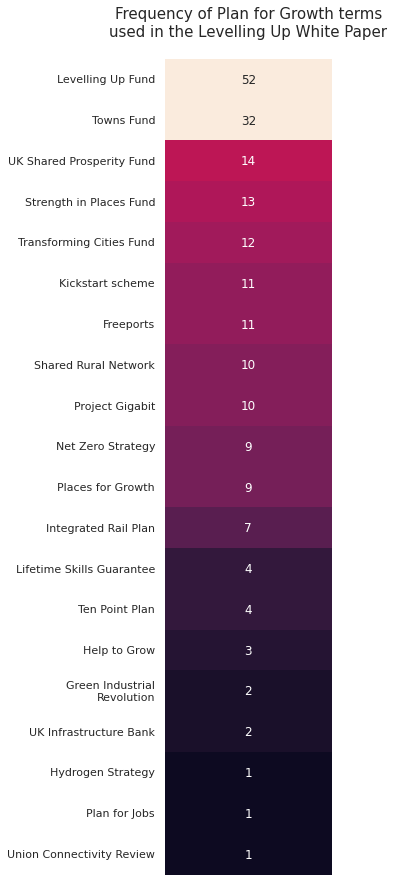

In [ ]:
#@title Heatmap of Plan for Growth terms Part I
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_planforgrowth.iloc[0:20],
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = False,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of Plan for Growth terms\nused in the Levelling Up White Paper\n",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of Plan for Growth terms\nused in the Levelling Up White Paper\n(continued)')

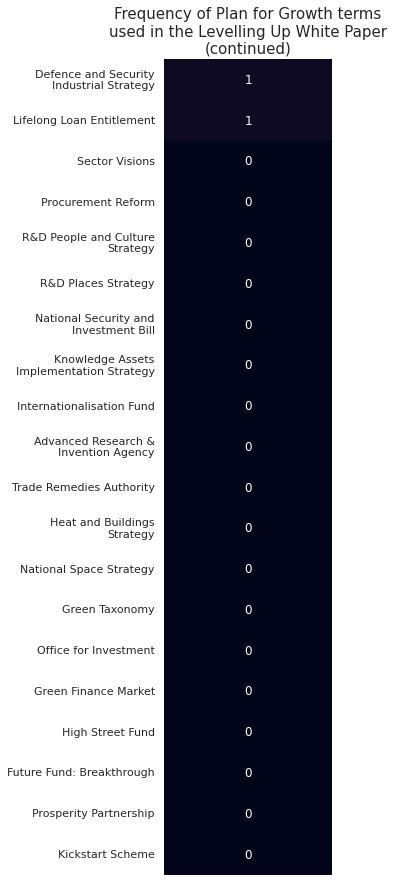

In [ ]:
#@title Heatmap of Plan for Growth terms Part II
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_planforgrowth.iloc[20:40],
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = False,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of Plan for Growth terms\nused in the Levelling Up White Paper\n(continued)",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of Plan for Growth terms\nused in the Levelling Up White Paper\n(continued)')

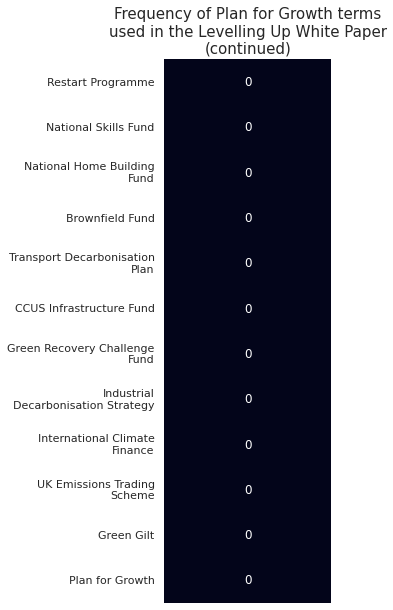

In [ ]:
#@title Heatmap of Plan for Growth terms Part III
# Set the width and height of the figure
plt.figure(figsize = (3, 10))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_planforgrowth.iloc[40:],
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = False,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of Plan for Growth terms\nused in the Levelling Up White Paper\n(continued)",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of Innovation Strategy terms\nused in the Levelling Up White Paper\n')

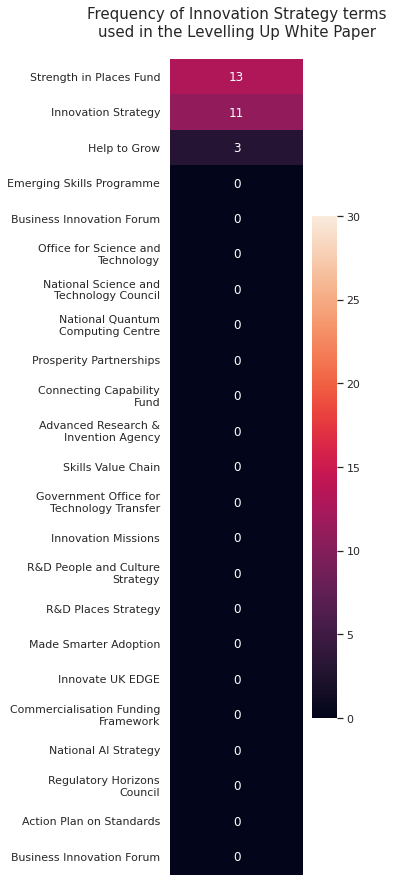

In [ ]:
#@title Heatmap of Innovation Strategy terms Part I
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_innovationstrategy,
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = True,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of Innovation Strategy terms\nused in the Levelling Up White Paper\n",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of Innovation Strategy terms\nused in the Levelling Up White Paper\n(continued)')

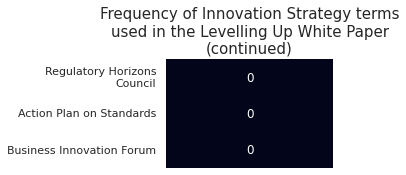

In [ ]:
#@title Heatmap of Innovation Strategy terms Part II
# Set the width and height of the figure
plt.figure(figsize = (3, 2))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_innovationstrategy.iloc[20:],
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = False,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of Innovation Strategy terms\nused in the Levelling Up White Paper\n(continued)",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of 2017 Industrial Strategy terms\nused in the Levelling Up White Paper\n')

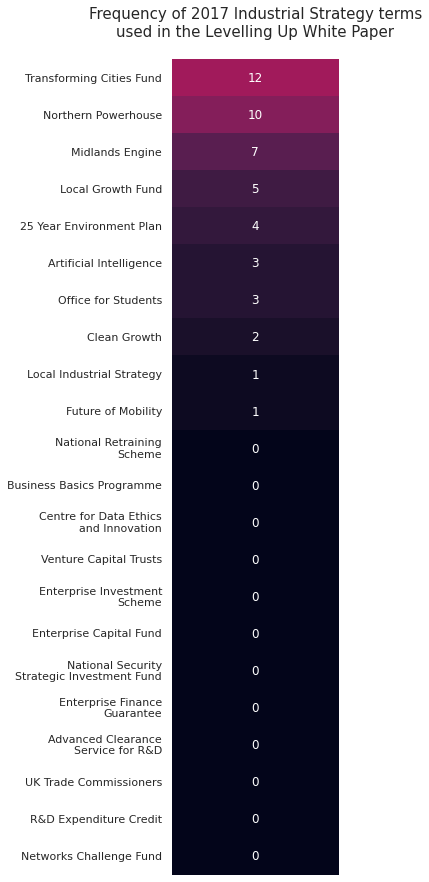

In [ ]:
#@title Heatmap of 2017 Industrial Strategy terms Part I
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_industrialstrategy.iloc[0:22],
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = False,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of 2017 Industrial Strategy terms\nused in the Levelling Up White Paper\n",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of 2017 Industrial Strategy terms\nused in the Levelling Up White Paper\n(continued)')

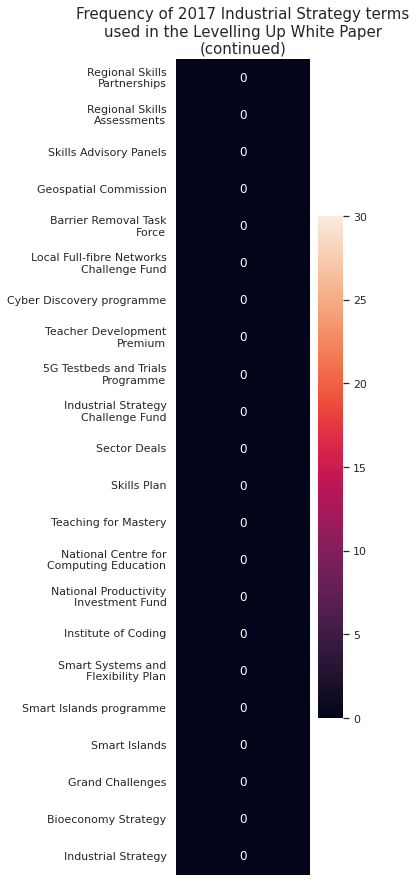

In [ ]:
#@title Heatmap of 2017 Industrial Strategy terms Part I
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_industrialstrategy.iloc[22:],
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = True,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 25)
dluhc_heatmap

# Add titles
plt.title("Frequency of 2017 Industrial Strategy terms\nused in the Levelling Up White Paper\n(continued)",
          fontsize = 15)

Text(0.5, 1.0, 'Frequency of economic sector terms from\nthe Plan for Growth and\n2017 Industrial Strategy\nused in the Levelling Up White Paper\n')

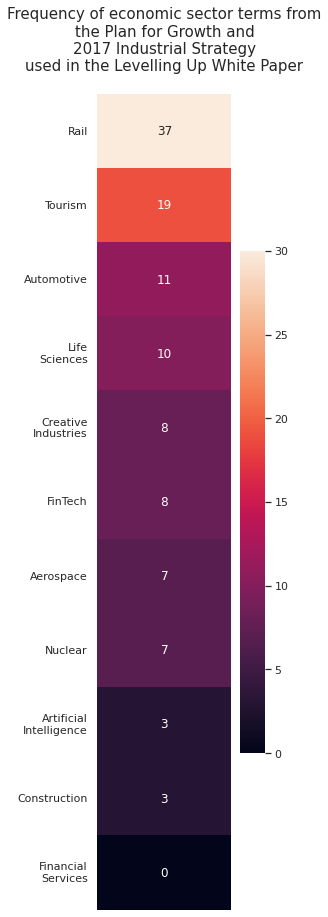

In [ ]:
#@title Heatmap of Economic Strategy terms
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Bar 
sns.set(font_scale = 1)
dluhc_heatmap = sns.heatmap(dluhc_economicsector,
                            annot = True,
                            vmin = 0,
                            vmax = 30,
                            cmap = pal,
                            cbar = True,
                            xticklabels = False,
                            fmt = "g")
wrap_xlabels(dluhc_heatmap, 15)
wrap_ylabels(dluhc_heatmap, 12)
dluhc_heatmap

# Add titles
plt.title("Frequency of economic sector terms from\nthe Plan for Growth and\n2017 Industrial Strategy\nused in the Levelling Up White Paper\n",
          fontsize = 15)

In [ ]:
#@title Exporting dataframes as CSV files (if required for further analysis on Microsoft Excel)
dluhc_planforgrowth.to_csv('/content/dluhc_planforgrowth.csv', index = True)
dluhc_innovationstrategy.to_csv('/content/dluhc_innovationstrategy.csv', index = True)
dluhc_industrialstrategy.to_csv('/content/dluhc_industrialstrategy.csv', index = True)
dluhc_economicsector.to_csv('/content/dluhc_economicsector.csv', index = True)